In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tqdm
import multiprocessing as mp
from config import *

result_directory = result_parent_directory + os.sep + 'step3_btms_sizing' + os.sep + 'analysis'
os.makedirs(result_directory, exist_ok=True)
figure_directory = result_parent_directory + os.sep + 'step3_btms_sizing' + os.sep + 'figures'
os.makedirs(figure_directory, exist_ok=True)

In [16]:
#import step3_btms_sizing results
sizing_results_path = os.path.join(result_parent_directory, 'step3_btms_sizing')

# load all results from path to list and add taz name as df name
sizing_results = []
for file in os.listdir(sizing_results_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(sizing_results_path, file), index_col=0)
        name = file.split('.')[0]
        #remove btms_sizing from name
        df.name = name.split('_')[2]
        sizing_results.append(df)

In [17]:
sizing_results[0].head(4)

,time,time_x,P_Grid,P_BTMS,E_BTMS,P_Charge,P_BTMS_Ch,P_BTMS_DCh,"param: btms size, a,b_sys,b_cap,b_loan,c"
0,60.0,60,26.702102,26.702102,10.098402,0.0,26.702102,-2.127725e-07,183.728820
1,120.0,120,26.702102,26.702102,10.476682,0.0,26.702102,-2.127704e-07,0.657534
2,180.0,180,26.702102,26.702102,10.854962,0.0,26.702102,-2.127687e-07,0.043240
3,240.0,240,26.702102,26.702102,11.233242,0.0,26.702102,-2.127673e-07,0.023148


In [22]:
from functions.stats_sizing_function import stats_sizing_function
# create df with stats for each taz
stats = pd.DataFrame()
for df in sizing_results:
    stats = stats.append(pd.DataFrame(stats_sizing_function(df, timestep), index=[df.name]))
# save stats
stats.to_csv(os.path.join(result_directory, 'stats.csv'))

In [23]:
stats.describe()

,btms_size,cost_a,cost_b_sys,cost_b_cap,cost_b_loan,cost_b,cost_c,cost_total,share_cost_a,share_cost_b_sys,share_cost_b_cap,share_cost_b_loan,share_cost_b,share_cost_c,E_Charge,c_rate,cycles_day,btms_ratio,load_factor,btms_peak_to_grid_ratio
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,1.570000e+02,157.000000
mean,295.358807,21.495443,19.962635,15.466540,6.241895,35.429175,12.042564,68.967182,0.292921,0.319929,0.217711,0.087862,0.537640,0.169439,683.684094,1.842134,1.934346,0.874991,1.000000e+00,19.271462
std,149.299629,13.513053,7.832275,8.009169,3.232293,13.811848,6.250794,32.432644,0.059762,0.118253,0.034055,0.013744,0.084999,0.026503,441.610667,0.910705,0.493284,0.071289,2.708499e-08,15.050063
min,43.676827,1.416649,6.189802,1.188625,0.479698,9.841876,0.920612,16.404684,0.086356,0.101904,0.072456,0.029242,0.374373,0.056119,44.000000,0.439286,1.000000,0.558255,9.999998e-01,3.735563
25%,192.229934,12.189825,12.349002,9.562589,3.859213,24.131608,7.445391,47.317450,0.258971,0.236645,0.201417,0.081287,0.475964,0.156733,382.416667,1.238611,1.556350,0.834513,1.000000e+00,10.612225
50%,275.933599,20.709969,20.797222,15.527903,6.266659,35.639843,12.019689,66.133615,0.295631,0.304801,0.222958,0.089980,0.531277,0.174288,651.916667,1.667213,1.907884,0.878088,1.000000e+00,15.811349
75%,390.317113,27.602592,24.575555,19.954682,8.053192,43.658401,15.537058,85.643349,0.336453,0.385157,0.239977,0.096848,0.581114,0.186184,878.083333,2.249184,2.230769,0.929953,1.000000e+00,22.227513
max,1022.899386,88.999826,52.763059,48.064905,19.397750,100.827964,38.115752,224.264558,0.441342,0.785068,0.272469,0.109962,0.857525,0.216401,2957.166667,6.819303,3.681218,0.992655,1.000000e+00,138.244317


In [24]:
# get taz with highest c rate
stats.sort_values(by='c_rate', ascending=False).head(1)

,btms_size,cost_a,cost_b_sys,cost_b_cap,cost_b_loan,cost_b,cost_c,cost_total,share_cost_a,share_cost_b_sys,share_cost_b_cap,share_cost_b_loan,share_cost_b,share_cost_c,E_Charge,c_rate,cycles_day,btms_ratio,load_factor,btms_peak_to_grid_ratio
700,43.676827,1.416649,12.878798,1.188625,0.479698,14.067423,0.920612,16.404684,0.086356,0.785068,0.072456,0.029242,0.857525,0.056119,44.0,6.819303,1.0,0.992655,1.0,138.244317


In [25]:
# plot results
from tqdm import tqdm
for df in tqdm(sizing_results):
    pltSettings()
    # use seaborn style
    plt.style.use('seaborn')
    # box around legend
    plt.rcParams['legend.frameon'] = True
    fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [2, 1]} )
    time_in_h = df['time']/3600
    stats_i = stats_sizing_function(df, timestep)

    btms_size = df['param: btms size, a,b_sys,b_cap,b_loan,c'].iloc[0]

    ax[0].step(time_in_h, df['P_BTMS'], label=r'$P_\Theta$')
    ax[0].step(time_in_h, df['P_Charge'], label=r'$P_{Charge}$')
    ax[0].step(time_in_h, df['P_Grid'], label=r'$P_{Grid}$')
    ax[0].set_title('Power usage at ' + df.name)
    ax[0].set_ylabel('Power [kW]')
    # legend outside of plot
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[1].plot(time_in_h, df['E_BTMS'] - df['E_BTMS'].min(), label=r'$E_\Theta$')
    ax[1].hlines(btms_size, 0, max(time_in_h), label='BTMS-Size', linestyles='dashed')
    ax[1].set_ylabel('Energy [kWh]')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[1].set_xlabel('Time [h]')
    ax[1].set_xlim(0, max(time_in_h))

    # add text box with informations, costs and sizing results
    textstr1 = '\n'.join([
        r'$cost_{a}= \$ %.2f$' % stats_i['cost_a'],
        r'$cost_{b}= \$ %.2f$' % stats_i['cost_b'],
        r'$cost_{c}= \$ %.2f$' % stats_i['cost_c'],
        r'$cost_{total}= \$ %.2f$' % stats_i['cost_total'],])
    textstr2 = '\n'.join([
        r'$BTMS-Size =%.2f$ kWh' % stats_i['btms_size'],
        r'$\max{P_{\Theta}}=%.2f$ kW' % df['P_BTMS'].abs().max(),
        r'$\max{P_{Grid}}=%.2f$ kW' % df['P_Grid'].max(),
        r'C-Rate: %.2f' % stats_i['c_rate'],
        r'Cycles: %.2f' % stats_i['cycles_day'],
        r'BTMS-Ratio: %.2f' % stats_i['btms_ratio'],
        r'Load-Factor(Grid): %.2f' % stats_i['load_factor'],
        ])
    textstr = '\n'.join([
        textstr1, 
        textstr2])
    
    # add text under legend of first plot
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[0].text(1.05, 0.10, textstr, transform = ax[0].transAxes, fontsize = 10, bbox=props, va='bottom', ha='left')

    plt.savefig(os.path.join(figure_directory, df.name + '_btms_sizing.png'), dpi=300, bbox_inches='tight')
    plt.close()

100%|██████████| 157/157 [03:52<00:00,  1.48s/it]


$\mathrm{cost}_{a}= \$ 28.35$
$\mathrm{cost}_{b}= \$ 31.36$
$\mathrm{cost}_{c}= \$ 16.26$
$\mathrm{cost}_{total}= \$ 75.98$


$\mathrm{BTMS-Size} =301 \mathrm{kWh}$
$\mathrm{E}_\mathrm{Charge} =899 \mathrm{kWh}$
$\max{P_{\Theta}}=257 \mathrm{kW}$
$\max{P_{Grid}}=43 \mathrm{kW}$


$\mathrm{C-Rate}= 0.85$
$\mathrm{Cycles}= 2.45$
$\mathrm{BTMS-Ratio}= 0.82$
$f_\mathrm{load}= 1.00$


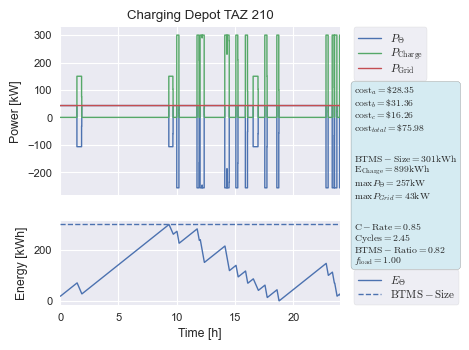

In [26]:
# plot result for paper
choosen_depot = '210'
#choosen_depot = '1374'
for df in sizing_results:
    if df.name == choosen_depot:
        # use seaborn style
        #plt.style.use('seaborn')
        plt.style.use('seaborn-paper')
        pltSettings()
        plt.rcParams["mathtext.fontset"] = "cm"
        plt.rcParams["lines.linewidth"] = 1
        # box around legend
        plt.rcParams['legend.frameon'] = True
        fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [2, 1]} )
        time_in_h = df['time']/3600
        stats_i = stats_sizing_function(df, timestep)

        btms_size = df['param: btms size, a,b_sys,b_cap,b_loan,c'].iloc[0]

        ax[0].step(time_in_h, df['P_BTMS'], label=r'$P_\mathrm{\Theta}$')
        ax[0].step(time_in_h, df['P_Charge'], label=r'$P_{\mathrm{Charge}}$')
        ax[0].step(time_in_h, df['P_Grid'], label=r'$P_{\mathrm{Grid}}$')
        ax[0].set_title('Charging Depot TAZ ' + df.name)
        ax[0].set_ylabel('Power [kW]')
        # legend outside of plot
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., labelspacing=0)
        #ax[0].legend(loc = 'upper left')
        ax[1].plot(time_in_h, df['E_BTMS'] - df['E_BTMS'].min(), label=r'$E_\Theta$')
        ax[1].hlines(btms_size, 0, max(time_in_h), label=r'$\mathrm{BTMS-Size}$', linestyles='dashed')
        ax[1].set_ylabel('Energy [kWh]')
        ax[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., labelspacing=0)
        #ax[1].legend(loc = 'upper left')
        ax[1].set_xlabel('Time [h]')
        ax[1].set_xlim(0, max(time_in_h))

        # add text box with informations, costs and sizing results
        textstr1 = '\n'.join([
            r'$\mathrm{cost}_{a}= \$ %.2f$' % stats_i['cost_a'],
            r'$\mathrm{cost}_{b}= \$ %.2f$' % stats_i['cost_b'],
            r'$\mathrm{cost}_{c}= \$ %.2f$' % stats_i['cost_c'],
            r'$\mathrm{cost}_{total}= \$ %.2f$' % stats_i['cost_total'],])
        textstr2 = '\n'.join([
            '\n',
            r'$\mathrm{BTMS-Size} =%.0f \mathrm{kWh}$' % stats_i['btms_size'],
            r'$\mathrm{E}_\mathrm{Charge} =%.0f \mathrm{kWh}$' % stats_i['E_Charge'],
            r'$\max{P_{\Theta}}=%.0f \mathrm{kW}$' % df['P_BTMS'].abs().max(),
            r'$\max{P_{Grid}}=%.0f \mathrm{kW}$' % df['P_Grid'].max(),
            '\n',
            r'$\mathrm{C-Rate}= %.2f$' % stats_i['c_rate'],
            r'$\mathrm{Cycles}= %.2f$' % stats_i['cycles_day'],
            r'$\mathrm{BTMS-Ratio}= %.2f$' % stats_i['btms_ratio'],
            r'$f_\mathrm{load}= %.2f$' % stats_i['load_factor'],
            ])
        textstr = '\n'.join([
            textstr1, 
            textstr2])
        print(textstr)
        # reduce spacing between text with latex
        fig.set_size_inches(plotSizeX, 3*plotSizeY)
        # add text under legend of first plot
        props = dict(boxstyle='round', facecolor = 'lightblue', alpha=0.5)
        ax[0].text(1.05, 0.12, textstr, transform = ax[0].transAxes, fontsize = 7, bbox=props, va='center', ha='left', linespacing = 1, math_fontfamily='cm')

        plt.savefig(os.path.join(figure_directory, 'a_for_paper_trajectories' + df.name + '_btms_sizing.pdf'), dpi=300, bbox_inches='tight')

### stats analysis


In [27]:
stats_described = stats.describe()
# choose columns to keep
stats_described = stats_described[['share_cost_a', 'share_cost_b', 'share_cost_c', 'btms_size', 'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor']]
# choose rows to keep
stats_described = stats_described.loc[['mean', 'std', 'min', 'max']]
# rename columns
stats_described.columns = [r'$\frac{\text{cost}_\text{a}}{\text{cost}_\text{total}}$', r'$\frac{\text{cost}_\text{b}}{\text{cost}_\text{total}}$', r'$\frac{\text{cost}_\text{c}}{\text{cost}_\text{total}}$', r'BTMS-Size [\unit{\kWh}]', r'$E_\text{Charge}$ [\unit{\kWh}]', 'C-Rate', 'Cycles', 'BTMS-Ratio', r'$f_\text{load}$']
# rename rows
stats_described.index = ['$\mu$', '$\sigma$', '$\min$', '$\max$']
# round values
stats_described = stats_described.round(2)
# export to latex
stats_described.to_latex(os.path.join(result_directory, 'stats_step3_described.tex'), escape=False)
stats_described

,$\frac{\text{cost}_\text{a}}{\text{cost}_\text{total}}$,$\frac{\text{cost}_\text{b}}{\text{cost}_\text{total}}$,$\frac{\text{cost}_\text{c}}{\text{cost}_\text{total}}$,BTMS-Size [\unit{\kWh}],$E_\text{Charge}$ [\unit{\kWh}],C-Rate,Cycles,BTMS-Ratio,$f_\text{load}$
$\mu$,0.29,0.54,0.17,295.36,683.68,1.84,1.93,0.87,1.0
$\sigma$,0.06,0.08,0.03,149.30,441.61,0.91,0.49,0.07,0.0
$\min$,0.09,0.37,0.06,43.68,44.00,0.44,1.00,0.56,1.0
$\max$,0.44,0.86,0.22,1022.90,2957.17,6.82,3.68,0.99,1.0


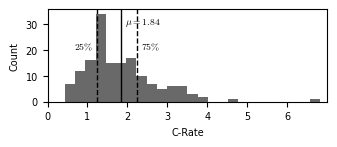

In [35]:
plt.style.use('default')
pltSettings()
# set font size to 7
stats['c_rate'].hist(bins = 25, color = 'dimgrey')
# use standard style
# turn grid off
plt.grid(False)
fig = plt.gcf()
fig.set_size_inches(plotSizeX, plotSizeY)
plt.xlabel('C-Rate')
plt.ylabel('Count')
# plot mean
plt.axvline(stats['c_rate'].mean(), color='k', linewidth=1)
# add text with mean
plt.text(stats['c_rate'].mean() + 0.1, 30, r'$\mu=%.2f$' % stats['c_rate'].mean(), fontsize = 7)
# plot 25 to 75 percentiles
quant = stats["c_rate"].quantile([0.25, 0.75])
ax = plt.gca()
ax.axvline(quant[0.25], color='k', linestyle='dashed', linewidth=1)
ax.axvline(quant[0.75], color='k', linestyle='dashed', linewidth=1)
# add text at 25 and 75 percentile
ax.text(quant[0.25]-0.1, 20, r"$25\%$", color='k', horizontalalignment='right', fontsize = 7)
ax.text(quant[0.75]+0.1, 20, r"$75\%$", color='k', horizontalalignment='left', fontsize = 7)
# x ticks 
ax.set_xlim(0, 7)
plt.xticks(np.arange(0, 7, 1))

plt.savefig(os.path.join(figure_directory, 'c_rate_histogram.pdf'), dpi=300, bbox_inches='tight')